# 0.0 Original

The average contour height for C:/Users/hezro/Desktop/para5_blur.png is: 969.50 pixels
The most common contour height for C:/Users/hezro/Desktop/para5_blur.png is: 1871 pixels


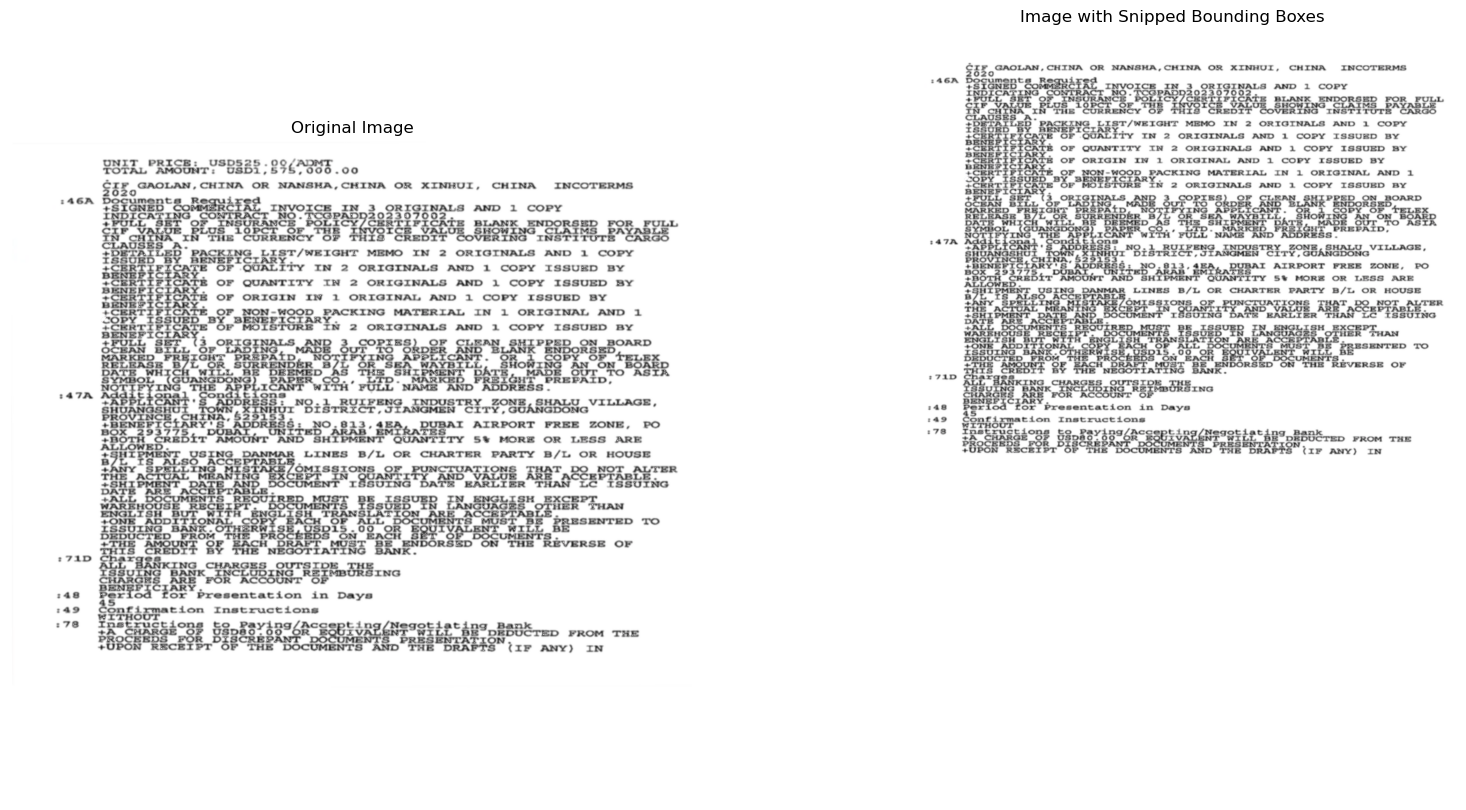

In [92]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from wand.image import Image
from collections import Counter
from cv2 import dnn_superres

# Paths to images
image_paths = [
    'C:/Users/hezro/Desktop/para5_blur.png',
]

# Model path for super resolution
model_path = "C:/Users/hezro/Desktop/OpenCV Test/test03/FSRCNN-small_x3.pb"

# Function to calculate skew angle
def getSkewAngle(cvImage) -> float:
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)
    contours, _ = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    elif angle > 45:
        angle = angle - 90
    return -angle

# Function to rotate the image
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    # Use cv2.BORDER_CONSTANT with borderValue set to white
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    return newImage

# Function to deskew the image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

# Function to remove non-greyscale colors using color thresholding
def remove_other_colors(image_path, output_path):
    # Load the image
    img = cv2.imread(image_path)
    
    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define the range of non-greyscale colors <------------------------- (lower and upper bound) -------------------------------------------------
    lower_bound = np.array([0, 10, 50])   # Lower bound for non-greyscale colors
    upper_bound = np.array([179, 255, 255])  # Upper bound for non-greyscale colors
    
    # Create a mask for non-greyscale colors
    mask = cv2.inRange(hsv, lower_bound, upper_bound)
    
    # Invert the mask to get greyscale regions
    mask_inv = cv2.bitwise_not(mask)
    
    # Convert mask to 3 channels
    mask_inv = cv2.cvtColor(mask_inv, cv2.COLOR_GRAY2BGR)
    
    # Apply the mask to the image
    result = cv2.bitwise_and(img, mask_inv)
    
    # Convert masked non-greyscale colors to white
    result[mask == 255] = [255, 255, 255]
    
    # Save the modified image
    cv2.imwrite(output_path, result)

def deskew_with_wand(image):
    """
    Deskew an image using Wand (ImageMagick).

    Parameters:
    - image: numpy.ndarray, input image array (BGR format).

    Returns:
    - deskewed_img: numpy.ndarray, deskewed image array (BGR format).
    """
    # Convert BGR image array to RGB for Wand compatibility
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create Wand Image object
    with Image(blob=cv2.imencode('.png', rgb_img)[1]) as wand_img:
        wand_img.deskew(0.6 * wand_img.quantum_range)
        deskew_img_rgb = np.array(wand_img)

    # Convert RGB image array back to BGR
    deskew_img = cv2.cvtColor(deskew_img_rgb, cv2.COLOR_RGB2BGR)
    
    return deskew_img

# Processing each image
for index, image_path_ori in enumerate(image_paths):
    # Read the original image using OpenCV
    img_ori = cv2.imread(image_path_ori)
    
    # Check if the image is loaded correctly
    if img_ori is None:
        raise ValueError(f"Could not load image from {image_path_ori}")
        
    #============================================================================================================================================================
    
    # Create an SR object
    sr = dnn_superres.DnnSuperResImpl_create()

    # Read image
    image = img_ori

    # Read the desired model
    sr.readModel(model_path)

    # Set the desired model and scale to get correct pre- and post-processing
    sr.setModel("fsrcnn", 3)

    # Upscale the image
    upscale_img = sr.upsample(image)

    # Save the upscaled image temporarily (because the variable "upscale_img" format is in numpy array) 
    upscaled_path = "upscaled_image.png"
    cv2.imwrite(upscaled_path, upscale_img)

    # Remove non-greyscale colors from the upscaled image
    remove_other_colors(upscaled_path, upscaled_path)

    # Reload the modified image
    upscale_img = cv2.imread(upscaled_path)

    #========================================================================================================================================================
    
    # Deskew the image using OpenCV
    deskew_img = deskew(upscale_img)
    
    #Deskew the image using Wand
    deskew_img = deskew_with_wand(deskew_img)

    # Convert the deskewed image to RGB for further processing
    deskew_img_rgb = cv2.cvtColor(deskew_img, cv2.COLOR_BGR2RGB)

    #========================================================================================================================================================
    
    # Read the image
    img = deskew_img_rgb
    
    # Check if the image is loaded correctly
    if img is None:
        raise FileNotFoundError("Image file not found or unable to load.")

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Perform simple thresholding # <--------------------------------------------------GRAYSCALE THRESHOLD--------------------------------------------->
    _, thresh1 = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY_INV) # for chop1.png
    # _, thresh1 = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV) # for para5.png

    # Choose the kernel for dilation
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (200, 1))

    # Apply dilation
    dilation = cv2.dilate(thresh1, rect_kernel, iterations=1)

    # Finding contours
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Initialize variables for calculating average contour height
    total_height = 0
    num_contours = 0

    noise_threshold = 11

    height_counter = Counter()

    # Process each contour to calculate the total height and count the contours
    for contour in contours:
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        
        # Skip bounding boxes with height less than 10 pixels
        if h < noise_threshold:
            continue
        
        # Accumulate total height and increment contour count
        total_height += h
        num_contours += 1
        
        # Track the frequency of each contour height
        height_counter[h] += 1

    # Calculate average contour height
    average_contour_height = total_height / num_contours if num_contours > 0 else 0

    # Determine the most common contour height
    most_common_height = height_counter.most_common(1)[0][0] if height_counter else 0

    print(f"The average contour height for {image_path_ori} is: {average_contour_height:.2f} pixels")
    print(f"The most common contour height for {image_path_ori} is: {most_common_height} pixels")

    # Create a copy of the original image to draw bounding boxes on it
    img_with_boxes = img.copy()

    bb_height = most_common_height + 4
    bounding_boxes = []

    # Process each contour to extract bounding boxes
    for contour in contours:
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        
        # Skip bounding boxes with height less than 10 pixels
        if h < noise_threshold:
            continue
        
        # Draw the bounding box on the image copy
        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 1)

        # Determine number of splits needed
        num_splits = int(h / bb_height)
        if (h / bb_height) - num_splits >= 0.4:
            num_splits += 1

        # Collect each split bounding box
        for i in range(num_splits):
            start_y = y + i * bb_height
            end_y = min(y + (i + 1) * bb_height, y + h)
            bounding_boxes.append((x, start_y, x + w, end_y))

    # Sort bounding boxes by the y-coordinate (start_y) in ascending order
    bounding_boxes = sorted(bounding_boxes, key=lambda box: box[1])

    # Create a white image with height larger than the original
    taller_height = img.shape[0] + 1500  # Increase height by 1000 pixels
    white_img = np.ones((taller_height, img.shape[1], 3), dtype=np.uint8) * 255

    spacing_pixel = 20

    # Process each bounding box and place them with incrementing offset
    for i, (x1, y1, x2, y2) in enumerate(bounding_boxes):
        bbox = img[y1:y2, x1:x2]
        new_start_y = y1 + spacing_pixel * i
        new_end_y = y2 + spacing_pixel * i

        # Ensure the bounding box fits within the white image boundaries
        if new_end_y <= white_img.shape[0] and new_start_y < white_img.shape[0]:
            white_img[new_start_y:new_end_y, x1:x2] = bbox

    # Convert images to RGB for displaying using Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_with_boxes_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    white_img_rgb = cv2.cvtColor(white_img, cv2.COLOR_BGR2RGB)
    #========================================================================================================================================================
    
    # Save the final processed image based on the original image path
    output_path = image_paths[index].replace('.png', '_done.png')
    cv2.imwrite(output_path, white_img)

    # Display the original, original with bounding boxes, and final images side by side using Matplotlib
    plt.figure(figsize=(30, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(deskew_img_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(white_img_rgb)
    plt.title('Image with Snipped Bounding Boxes')
    plt.axis('off')

    plt.show()

# 1.0 (All functions) 

Laplacian Variance: 15774.372908634097, Grayscale Threshold: 50
The average contour height for C:/Users/hezro/Desktop/para5.png is: 31.32 pixels
The most common contour height for C:/Users/hezro/Desktop/para5.png is: 24 pixels


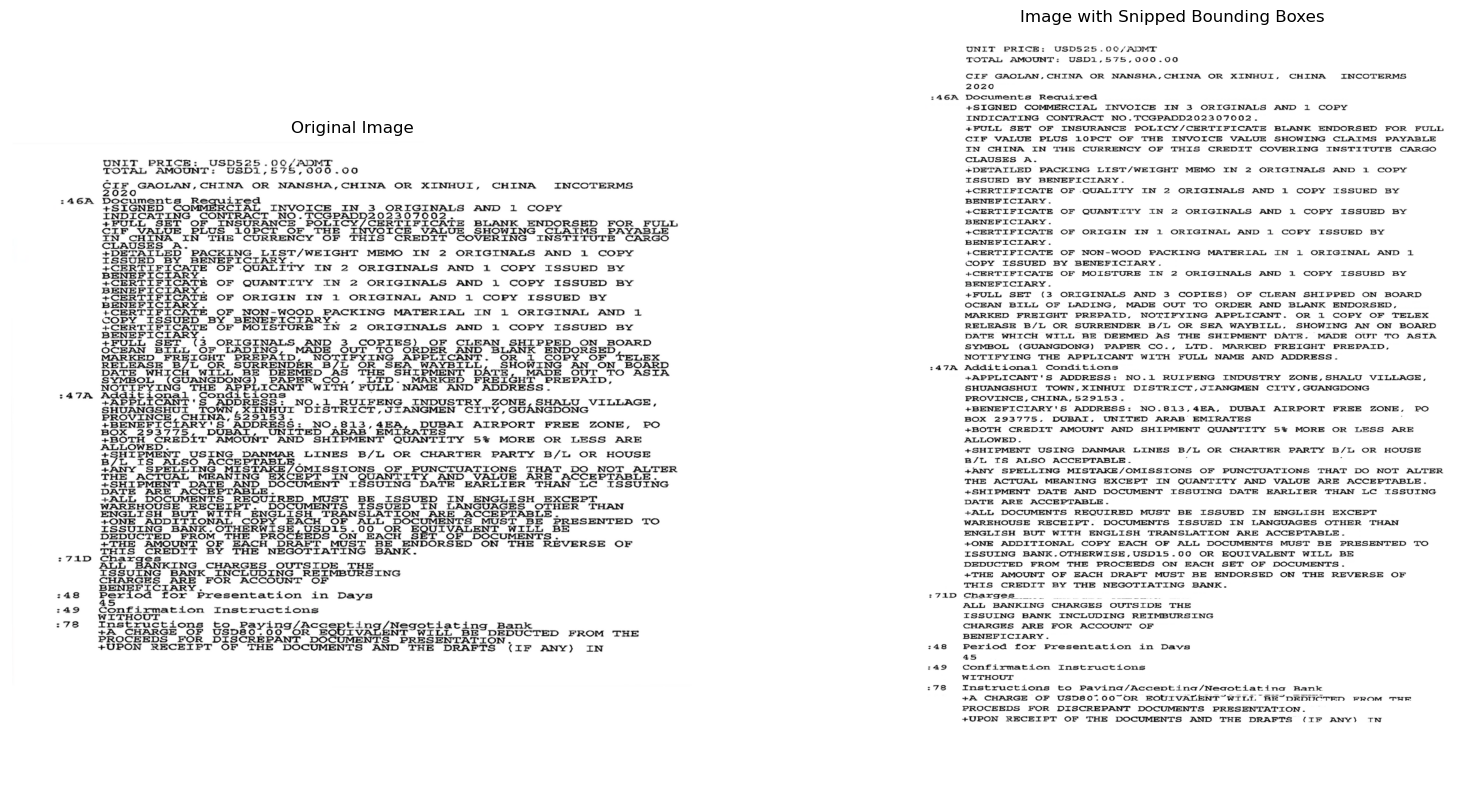

In [99]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from wand.image import Image
from collections import Counter
from cv2 import dnn_superres

# Paths to images
image_paths = [
    'C:/Users/hezro/Desktop/para5.png',
    
]

# Model path for super resolution
model_path = "C:/Users/hezro/Desktop/OpenCV Test/test03/FSRCNN-small_x3.pb"

# Function to calculate skew angle
def getSkewAngle(cvImage) -> float:
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)
    contours, _ = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    elif angle > 45:
        angle = angle - 90
    return -angle

# Function to rotate the image
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    # Use cv2.BORDER_CONSTANT with borderValue set to white
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    return newImage

# Function to deskew the image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

# Function to remove non-greyscale colors using color thresholding
def remove_other_colors(image_path, output_path):
    # Load the image
    img = cv2.imread(image_path)
    
    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define the range of non-greyscale colors <------------------------- (lower and upper bound) -------------------------------------------------
    lower_bound = np.array([0, 10, 50])   # Lower bound for non-greyscale colors
    upper_bound = np.array([179, 255, 255])  # Upper bound for non-greyscale colors
    
    # Create a mask for non-greyscale colors
    mask = cv2.inRange(hsv, lower_bound, upper_bound)
    
    # Invert the mask to get greyscale regions
    mask_inv = cv2.bitwise_not(mask)
    
    # Convert mask to 3 channels
    mask_inv = cv2.cvtColor(mask_inv, cv2.COLOR_GRAY2BGR)
    
    # Apply the mask to the image
    result = cv2.bitwise_and(img, mask_inv)
    
    # Convert masked non-greyscale colors to white
    result[mask == 255] = [255, 255, 255]
    
    # Save the modified image
    cv2.imwrite(output_path, result)

def deskew_with_wand(image):
    """
    Deskew an image using Wand (ImageMagick).

    Parameters:
    - image: numpy.ndarray, input image array (BGR format).

    Returns:
    - deskewed_img: numpy.ndarray, deskewed image array (BGR format).
    """
    # Convert BGR image array to RGB for Wand compatibility
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create Wand Image object
    with Image(blob=cv2.imencode('.png', rgb_img)[1]) as wand_img:
        wand_img.deskew(0.6 * wand_img.quantum_range)
        deskew_img_rgb = np.array(wand_img)

    # Convert RGB image array back to BGR
    deskew_img = cv2.cvtColor(deskew_img_rgb, cv2.COLOR_RGB2BGR)
    
    return deskew_img

def calculate_laplacian_variance(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian_variance = laplacian.var()
    return laplacian_variance
    
# Processing each image
for index, image_path_ori in enumerate(image_paths):
    # Read the original image using OpenCV
    img_ori = cv2.imread(image_path_ori)
    
    # Check if the image is loaded correctly
    if img_ori is None:
        raise ValueError(f"Could not load image from {image_path_ori}")
        
    #============================================================================================================================================================

    # Create a resized copy for Laplacian calculation
    resized_img = cv2.resize(img_ori.copy(), (594, 841))
    laplacian_variance = calculate_laplacian_variance(resized_img)
    
    # Set grayscale threshold based on Laplacian variance
    if laplacian_variance < 1000:
        grayscale_threshold = 230
    else:
        grayscale_threshold = 50

    print(f"Laplacian Variance: {laplacian_variance}, Grayscale Threshold: {grayscale_threshold}")

    #============================================================================================================================================================
   
    # Create an SR object
    sr = dnn_superres.DnnSuperResImpl_create()

    # Read image
    image = img_ori

    # Read the desired model
    sr.readModel(model_path)

    # Set the desired model and scale to get correct pre- and post-processing
    sr.setModel("fsrcnn", 3)

    # Upscale the image
    upscale_img = sr.upsample(image)

    # Save the upscaled image temporarily (because the variable "upscale_img" format is in numpy array) 
    upscaled_path = "upscaled_image.png"
    cv2.imwrite(upscaled_path, upscale_img)

    # Remove non-greyscale colors from the upscaled image
    remove_other_colors(upscaled_path, upscaled_path)

    # Reload the modified image
    upscale_img = cv2.imread(upscaled_path)

    #========================================================================================================================================================
    
    # Deskew the image using OpenCV
    deskew_img = deskew(upscale_img)
    
    #Deskew the image using Wand
    deskew_img = deskew_with_wand(deskew_img)

    # Convert the deskewed image to RGB for further processing
    deskew_img_rgb = cv2.cvtColor(deskew_img, cv2.COLOR_BGR2RGB)

    #========================================================================================================================================================
    
    # Read the image
    img = deskew_img_rgb
    
    # Check if the image is loaded correctly
    if img is None:
        raise FileNotFoundError("Image file not found or unable to load.")

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Perform simple thresholding # <--------------------------------------------------GRAYSCALE THRESHOLD--------------------------------------------->
    _, thresh1 = cv2.threshold(gray, grayscale_threshold, 255, cv2.THRESH_BINARY_INV) # for chop1.png
    # _, thresh1 = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV) # for para5.png

    # Choose the kernel for dilation
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (200, 1))

    # Apply dilation
    dilation = cv2.dilate(thresh1, rect_kernel, iterations=1)

    # Finding contours
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Initialize variables for calculating average contour height
    total_height = 0
    num_contours = 0

    noise_threshold = 11

    height_counter = Counter()

    # Process each contour to calculate the total height and count the contours
    for contour in contours:
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        
        # Skip bounding boxes with height less than 10 pixels
        if h < noise_threshold:
            continue
        
        # Accumulate total height and increment contour count
        total_height += h
        num_contours += 1
        
        # Track the frequency of each contour height
        height_counter[h] += 1

    # Calculate average contour height
    average_contour_height = total_height / num_contours if num_contours > 0 else 0

    # Determine the most common contour height
    most_common_height = height_counter.most_common(1)[0][0] if height_counter else 0

    print(f"The average contour height for {image_path_ori} is: {average_contour_height:.2f} pixels")
    print(f"The most common contour height for {image_path_ori} is: {most_common_height} pixels")

    # Create a copy of the original image to draw bounding boxes on it
    img_with_boxes = img.copy()

    bb_height = most_common_height + 4
    bounding_boxes = []

    # Process each contour to extract bounding boxes
    for contour in contours:
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        
        # Skip bounding boxes with height less than 10 pixels
        if h < noise_threshold:
            continue
        
        # Draw the bounding box on the image copy
        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 1)

        # Determine number of splits needed
        num_splits = int(h / bb_height)
        if (h / bb_height) - num_splits >= 0.4:
            num_splits += 1

        # Collect each split bounding box
        for i in range(num_splits):
            start_y = y + i * bb_height
            end_y = min(y + (i + 1) * bb_height, y + h)
            bounding_boxes.append((x, start_y, x + w, end_y))

    # Sort bounding boxes by the y-coordinate (start_y) in ascending order
    bounding_boxes = sorted(bounding_boxes, key=lambda box: box[1])

    # Create a white image with height larger than the original
    taller_height = img.shape[0] + 1500  # Increase height by 1000 pixels
    white_img = np.ones((taller_height, img.shape[1], 3), dtype=np.uint8) * 255

    spacing_pixel = 20

    # Process each bounding box and place them with incrementing offset
    for i, (x1, y1, x2, y2) in enumerate(bounding_boxes):
        bbox = img[y1:y2, x1:x2]
        new_start_y = y1 + spacing_pixel * i
        new_end_y = y2 + spacing_pixel * i

        # Ensure the bounding box fits within the white image boundaries
        if new_end_y <= white_img.shape[0] and new_start_y < white_img.shape[0]:
            white_img[new_start_y:new_end_y, x1:x2] = bbox

    # Convert images to RGB for displaying using Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_with_boxes_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    white_img_rgb = cv2.cvtColor(white_img, cv2.COLOR_BGR2RGB)
    #========================================================================================================================================================
    
    # Save the final processed image based on the original image path
    output_path = image_paths[index].replace('.png', '_done.png')
    cv2.imwrite(output_path, white_img)

    # Display the original, original with bounding boxes, and final images side by side using Matplotlib
    plt.figure(figsize=(30, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(deskew_img_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(white_img_rgb)
    plt.title('Image with Snipped Bounding Boxes')
    plt.axis('off')

    plt.show()


# 2.0 (Without Upscaling) 

The average contour height for C:/Users/hezro/Desktop/chop1.png is: 12.00 pixels
The most common contour height for C:/Users/hezro/Desktop/chop1.png is: 12 pixels


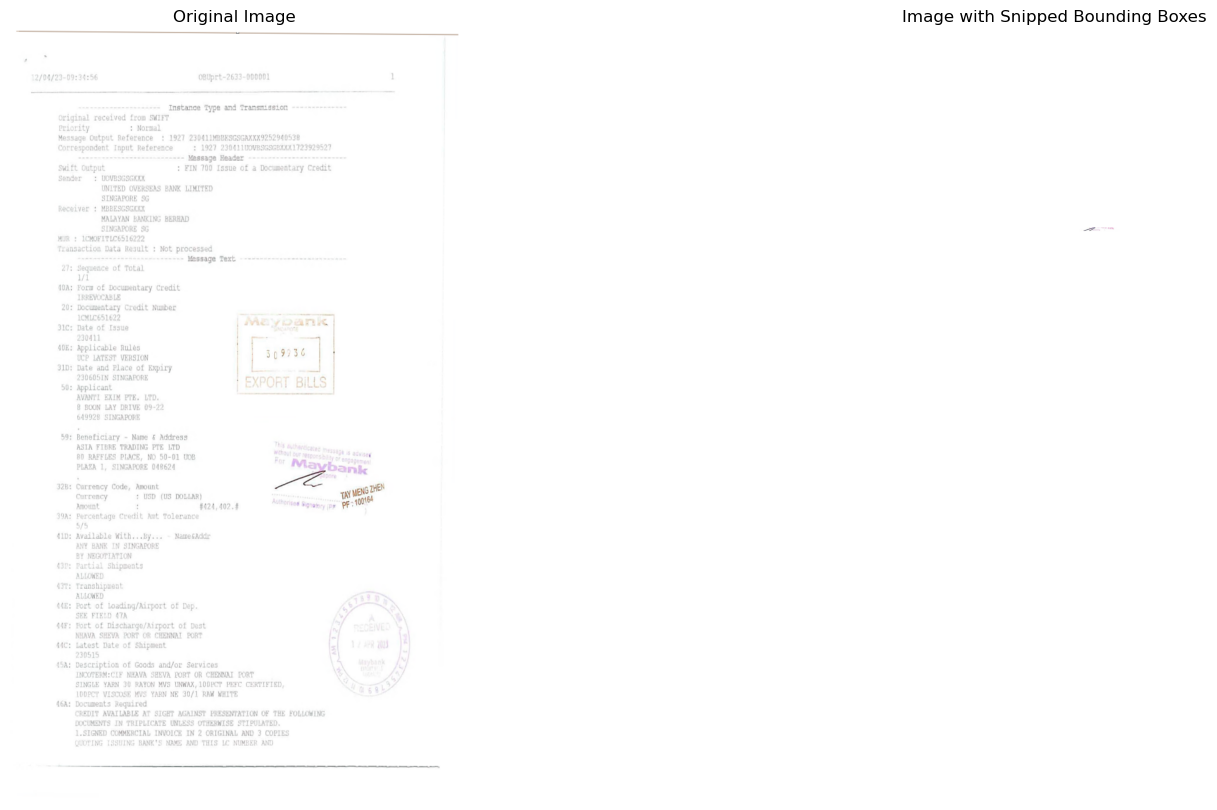

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from wand.image import Image
from collections import Counter
from cv2 import dnn_superres

# Paths to images
image_paths = [
    'C:/Users/hezro/Desktop/chop1.png',
]

# Model path for super resolution
# model_path = "C:/Users/hezro/Desktop/OpenCV Test/test03/FSRCNN-small_x3.pb"

# Function to calculate skew angle
def getSkewAngle(cvImage) -> float:
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)
    contours, _ = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    elif angle > 45:
        angle = angle - 90
    return -angle

# Function to rotate the image
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    # Use cv2.BORDER_CONSTANT with borderValue set to white
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    return newImage

# Function to deskew the image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

# Function to remove non-greyscale colors using color thresholding
def remove_other_colors(image_path, output_path):
    # Load the image
    img = cv2.imread(image_path)
    
    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define the range of non-greyscale colors <------------------------- (lower and upper bound) -------------------------------------------------
    lower_bound = np.array([0, 10, 50])   # Lower bound for non-greyscale colors
    upper_bound = np.array([179, 255, 255])  # Upper bound for non-greyscale colors
    
    # Create a mask for non-greyscale colors
    mask = cv2.inRange(hsv, lower_bound, upper_bound)
    
    # Invert the mask to get greyscale regions
    mask_inv = cv2.bitwise_not(mask)
    
    # Convert mask to 3 channels
    mask_inv = cv2.cvtColor(mask_inv, cv2.COLOR_GRAY2BGR)
    
    # Apply the mask to the image
    result = cv2.bitwise_and(img, mask_inv)
    
    # Convert masked non-greyscale colors to white
    result[mask == 255] = [255, 255, 255]
    
    # Save the modified image
    cv2.imwrite(output_path, result)

def deskew_with_wand(image):
    """
    Deskew an image using Wand (ImageMagick).

    Parameters:
    - image: numpy.ndarray, input image array (BGR format).

    Returns:
    - deskewed_img: numpy.ndarray, deskewed image array (BGR format).
    """
    # Convert BGR image array to RGB for Wand compatibility
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create Wand Image object
    with Image(blob=cv2.imencode('.png', rgb_img)[1]) as wand_img:
        wand_img.deskew(0.6 * wand_img.quantum_range)
        deskew_img_rgb = np.array(wand_img)

    # Convert RGB image array back to BGR
    deskew_img = cv2.cvtColor(deskew_img_rgb, cv2.COLOR_RGB2BGR)
    
    return deskew_img

# Processing each image
for index, image_path_ori in enumerate(image_paths):
    # Read the original image using OpenCV
    img_ori = cv2.imread(image_path_ori)
    
    # Check if the image is loaded correctly
    if img_ori is None:
        raise ValueError(f"Could not load image from {image_path_ori}")
        
    #============================================================================================================================================================
    
    # # Create an SR object
    # sr = dnn_superres.DnnSuperResImpl_create()

    # # Read image
    # image = img_ori

    # # Read the desired model
    # sr.readModel(model_path)

    # # Set the desired model and scale to get correct pre- and post-processing
    # sr.setModel("fsrcnn", 3)

    # # Upscale the image
    # upscale_img = sr.upsample(image)

    # # Save the upscaled image temporarily (because the variable "upscale_img" format is in numpy array) 
    # upscaled_path = "upscaled_image.png"
    # cv2.imwrite(upscaled_path, upscale_img)

    # # Remove non-greyscale colors from the upscaled image
    # remove_other_colors(upscaled_path, upscaled_path)

    # # Reload the modified image
    # upscale_img = cv2.imread(upscaled_path)

    #========================================================================================================================================================
    
    # Deskew the image using OpenCV
    # deskew_img = deskew(upscale_img)
    deskew_img = deskew(img_ori)
    
    #Deskew the image using Wand
    deskew_img = deskew_with_wand(deskew_img)

    # Convert the deskewed image to RGB for further processing
    deskew_img_rgb = cv2.cvtColor(deskew_img, cv2.COLOR_BGR2RGB)

    #========================================================================================================================================================
    
    # Read the image
    img = deskew_img_rgb
    
    # Check if the image is loaded correctly
    if img is None:
        raise FileNotFoundError("Image file not found or unable to load.")

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Perform simple thresholding
    # _, thresh1 = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
    _, thresh1 = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)

    # Choose the kernel for dilation
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (200, 1))

    # Apply dilation
    dilation = cv2.dilate(thresh1, rect_kernel, iterations=1)

    # Finding contours
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Initialize variables for calculating average contour height
    total_height = 0
    num_contours = 0

    noise_threshold = 11

    height_counter = Counter()

    # Process each contour to calculate the total height and count the contours
    for contour in contours:
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        
        # Skip bounding boxes with height less than 10 pixels
        if h < noise_threshold:
            continue
        
        # Accumulate total height and increment contour count
        total_height += h
        num_contours += 1
        
        # Track the frequency of each contour height
        height_counter[h] += 1

    # Calculate average contour height
    average_contour_height = total_height / num_contours if num_contours > 0 else 0

    # Determine the most common contour height
    most_common_height = height_counter.most_common(1)[0][0] if height_counter else 0

    print(f"The average contour height for {image_path_ori} is: {average_contour_height:.2f} pixels")
    print(f"The most common contour height for {image_path_ori} is: {most_common_height} pixels")

    # Create a copy of the original image to draw bounding boxes on it
    img_with_boxes = img.copy()

    bb_height = most_common_height + 4
    bounding_boxes = []

    # Process each contour to extract bounding boxes
    for contour in contours:
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        
        # Skip bounding boxes with height less than 10 pixels
        if h < noise_threshold:
            continue
        
        # Draw the bounding box on the image copy
        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 1)

        # Determine number of splits needed
        num_splits = int(h / bb_height)
        if (h / bb_height) - num_splits >= 0.4:
            num_splits += 1

        # Collect each split bounding box
        for i in range(num_splits):
            start_y = y + i * bb_height
            end_y = min(y + (i + 1) * bb_height, y + h)
            bounding_boxes.append((x, start_y, x + w, end_y))

    # Sort bounding boxes by the y-coordinate (start_y) in ascending order
    bounding_boxes = sorted(bounding_boxes, key=lambda box: box[1])

    # Create a white image with height larger than the original
    taller_height = img.shape[0] + 1500  # Increase height by 1000 pixels
    white_img = np.ones((taller_height, img.shape[1], 3), dtype=np.uint8) * 255

    spacing_pixel = 20

    # Process each bounding box and place them with incrementing offset
    for i, (x1, y1, x2, y2) in enumerate(bounding_boxes):
        bbox = img[y1:y2, x1:x2]
        new_start_y = y1 + spacing_pixel * i
        new_end_y = y2 + spacing_pixel * i

        # Ensure the bounding box fits within the white image boundaries
        if new_end_y <= white_img.shape[0] and new_start_y < white_img.shape[0]:
            white_img[new_start_y:new_end_y, x1:x2] = bbox

    # Convert images to RGB for displaying using Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_with_boxes_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    white_img_rgb = cv2.cvtColor(white_img, cv2.COLOR_BGR2RGB)
    #========================================================================================================================================================
    
    # Save the final processed image based on the original image path
    output_path = image_paths[index].replace('.png', '_done.png')
    cv2.imwrite(output_path, white_img)

    # Display the original, original with bounding boxes, and final images side by side using Matplotlib
    plt.figure(figsize=(30, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(deskew_img_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(white_img_rgb)
    plt.title('Image with Snipped Bounding Boxes')
    plt.axis('off')

    plt.show()


# 3.0 (Without Chop Removal)

The average contour height for C:/Users/hezro/Desktop/para6_line_removed.png is: 19.84 pixels
The most common contour height for C:/Users/hezro/Desktop/para6_line_removed.png is: 19 pixels


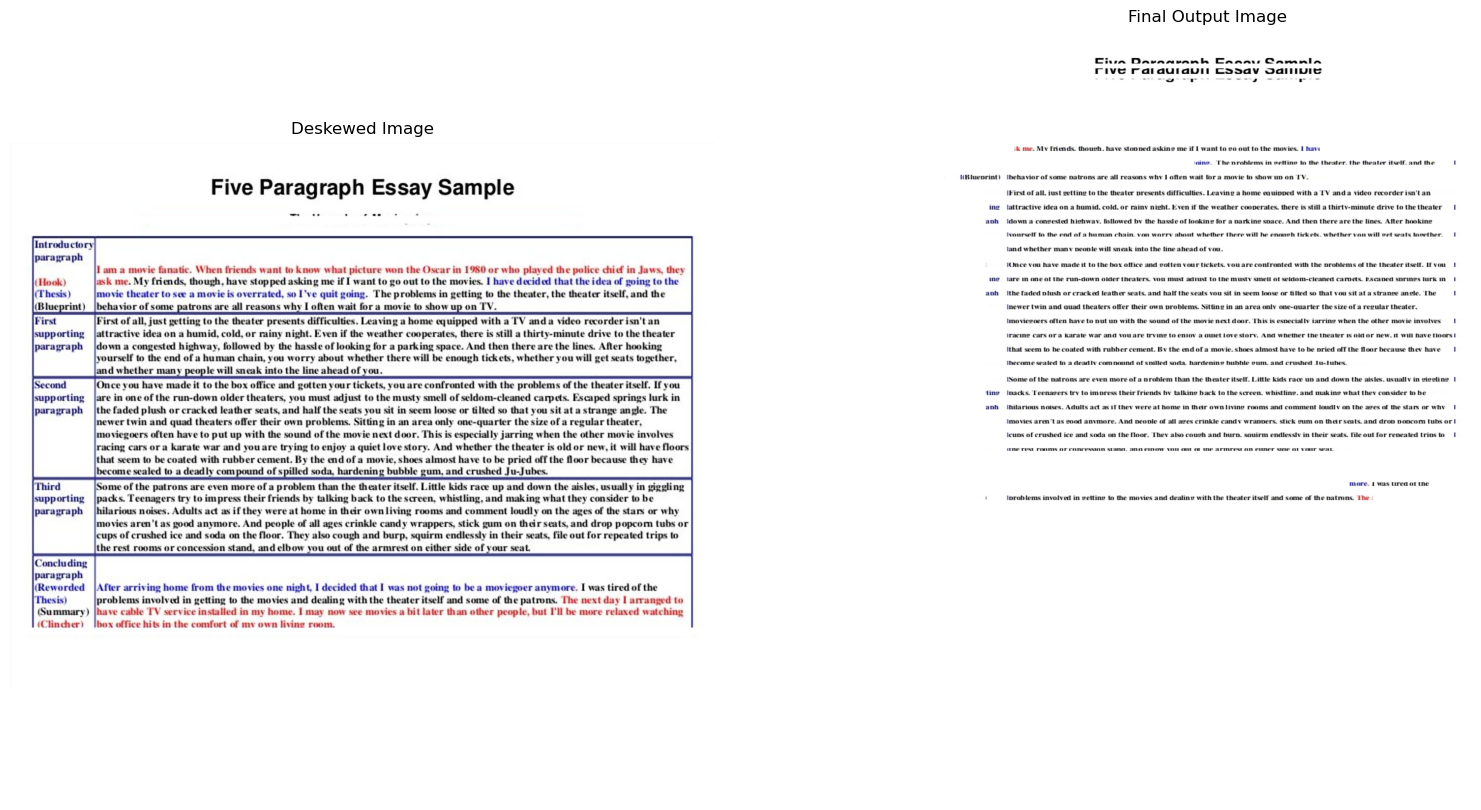

Processed C:/Users/hezro/Desktop/para6_line_removed.png. Final output saved to final_output_image_0.png


In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from wand.image import Image
from collections import Counter
from cv2 import dnn_superres

# Paths to images
image_paths = [
    'C:/Users/hezro/Desktop/para6_line_removed.png',
]

# Model path for super resolution
model_path = "C:/Users/hezro/Desktop/OpenCV Test/test03/FSRCNN-small_x3.pb"

# Function to calculate skew angle
def getSkewAngle(cvImage) -> float:
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)
    contours, _ = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    elif angle > 45:
        angle = angle - 90
    return -angle

# Function to rotate the image
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    # Use cv2.BORDER_CONSTANT with borderValue set to white
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    return newImage

# Function to deskew the image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

def deskew_with_wand(image):
    """
    Deskew an image using Wand (ImageMagick).

    Parameters:
    - image: numpy.ndarray, input image array (BGR format).

    Returns:
    - deskewed_img: numpy.ndarray, deskewed image array (BGR format).
    """
    # Convert BGR image array to RGB for Wand compatibility
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create Wand Image object
    with Image(blob=cv2.imencode('.png', rgb_img)[1]) as wand_img:
        wand_img.deskew(0.6 * wand_img.quantum_range)
        deskew_img_rgb = np.array(wand_img)

    # Convert RGB image array back to BGR
    deskew_img = cv2.cvtColor(deskew_img_rgb, cv2.COLOR_RGB2BGR)
    
    return deskew_img

# Processing each image
for index, image_path_ori in enumerate(image_paths):
    # Read the original image using OpenCV
    img_ori = cv2.imread(image_path_ori)
    
    # Check if the image is loaded correctly
    if img_ori is None:
        raise ValueError(f"Could not load image from {image_path_ori}")
        
    # Create an SR object
    sr = dnn_superres.DnnSuperResImpl_create()

    # Read image
    image = img_ori

    # Read the desired model
    sr.readModel(model_path)

    # Set the desired model and scale to get correct pre- and post-processing
    sr.setModel("fsrcnn", 3)

    # Upscale the image
    upscale_img = sr.upsample(image)

    # Save the upscaled image temporarily (because the variable "upscale_img" format is in numpy array) 
    upscaled_path = "upscaled_image.png"
    cv2.imwrite(upscaled_path, upscale_img)

    # Reload the modified image
    upscale_img = cv2.imread(upscaled_path)

    # Deskew the image using OpenCV
    deskew_img = deskew(upscale_img)
    
    # Deskew the image using Wand
    deskew_img = deskew_with_wand(deskew_img)

    # Convert the deskewed image to RGB for further processing
    deskew_img_rgb = cv2.cvtColor(deskew_img, cv2.COLOR_BGR2RGB)

    # Read the image
    img = deskew_img_rgb
    
    # Check if the image is loaded correctly
    if img is None:
        raise FileNotFoundError("Image file not found or unable to load.")

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Perform simple thresholding
    _, thresh1 = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY_INV)

    # Choose the kernel for dilation
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (200, 1))

    # Apply dilation
    dilation = cv2.dilate(thresh1, rect_kernel, iterations=1)

    # Finding contours
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Initialize variables for calculating average contour height
    total_height = 0
    num_contours = 0

    noise_threshold = 11

    height_counter = Counter()

    # Process each contour to calculate the total height and count the contours
    for contour in contours:
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        
        # Skip bounding boxes with height less than 10 pixels
        if h < noise_threshold:
            continue
        
        # Accumulate total height and increment contour count
        total_height += h
        num_contours += 1
        
        # Track the frequency of each contour height
        height_counter[h] += 1

    # Calculate average contour height
    average_contour_height = total_height / num_contours if num_contours > 0 else 0

    # Determine the most common contour height
    most_common_height = height_counter.most_common(1)[0][0] if height_counter else 0

    print(f"The average contour height for {image_path_ori} is: {average_contour_height:.2f} pixels")
    print(f"The most common contour height for {image_path_ori} is: {most_common_height} pixels")

    # Create a copy of the original image to draw bounding boxes on it
    img_with_boxes = img.copy()

    bb_height = most_common_height + 4
    bounding_boxes = []

    # Process each contour to extract bounding boxes
    for contour in contours:
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        
        # Skip bounding boxes with height less than 10 pixels
        if h < noise_threshold:
            continue
        
        # Draw the bounding box on the image copy
        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 1)

        # Determine number of splits needed
        num_splits = int(h / bb_height)
        if (h / bb_height) - num_splits >= 0.4:
            num_splits += 1

        # Collect each split bounding box
        for i in range(num_splits):
            start_y = y + i * bb_height
            end_y = min(y + (i + 1) * bb_height, y + h)
            bounding_boxes.append((x, start_y, x + w, end_y))

    # Sort bounding boxes by the y-coordinate (start_y) in ascending order
    bounding_boxes = sorted(bounding_boxes, key=lambda box: box[1])

    # Create a white image with height larger than the original
    taller_height = img.shape[0] + 1500  # Increase height by 1000 pixels
    white_img = np.ones((taller_height, img.shape[1], 3), dtype=np.uint8) * 255

    spacing_pixel = 20

    # Process each bounding box and place them with incrementing offset
    for i, (x1, y1, x2, y2) in enumerate(bounding_boxes):
        bbox = img[y1:y2, x1:x2]
        new_start_y = y1 + spacing_pixel * i
        new_end_y = y2 + spacing_pixel * i

        # Ensure the bounding box fits within the white image boundaries
        if new_end_y <= white_img.shape[0] and new_start_y < white_img.shape[0]:
            white_img[new_start_y:new_end_y, x1:x2] = bbox

    # Convert images to RGB for displaying using Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_with_boxes_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    white_img_rgb = cv2.cvtColor(white_img, cv2.COLOR_BGR2RGB)

    # Display the images using Matplotlib
    plt.figure(figsize=(20, 10))
    
    # Display the original deskewed image
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Deskewed Image")
    plt.axis('off')
    
    # # Display the image with bounding boxes
    # plt.subplot(1, 3, 2)
    # plt.imshow(img_with_boxes_rgb)
    # plt.title("Image with Bounding Boxes")
    # plt.axis('off')
    
    # Display the white image with arranged snippets
    plt.subplot(1, 2, 2)
    plt.imshow(white_img_rgb)
    plt.title("Final Output Image")
    plt.axis('off')
    
    # Show the plots
    plt.show()

    # Save the final output image
    final_output_path = f"final_output_image_{index}.png"
    cv2.imwrite(final_output_path, white_img)

    print(f"Processed {image_path_ori}. Final output saved to {final_output_path}")



# 4.0 Laplacian Detection

Laplacian Variance: 449.888568584665


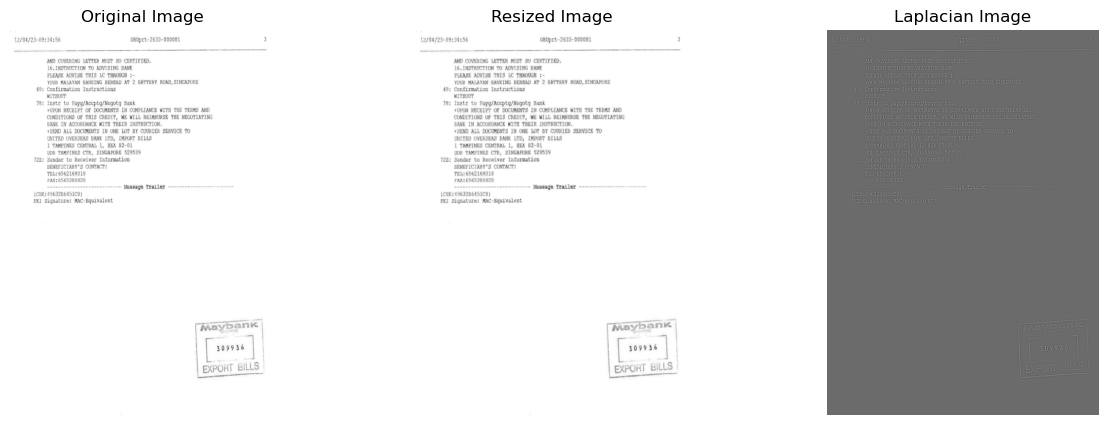

In [73]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_laplacian_value(image_path):
    # Load the image
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if original_image is None:
        raise ValueError("Image not found or unable to load the image.")
    
    # Create a copy of the image
    copied_image = original_image.copy()
    
    # Resize the copied image to 594x841
    resized_image = cv2.resize(copied_image, (594, 841))
    
    # Compute the Laplacian of the resized image
    laplacian = cv2.Laplacian(resized_image, cv2.CV_64F)
    
    # Calculate the variance of the Laplacian
    laplacian_variance = laplacian.var()
    
    return laplacian_variance, original_image, resized_image, laplacian

def plot_images(original, resized, laplacian):
    # Plot the original image, resized image, and the Laplacian image
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Resized Image")
    plt.imshow(resized, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Laplacian Image")
    plt.imshow(laplacian, cmap='gray')
    plt.axis('off')
    
    plt.show()

# Example usage
image_path = 'C:/Users/hezro/Desktop/chop2.png'
laplacian_variance, original_image, resized_image, laplacian_image = detect_laplacian_value(image_path)
print(f"Laplacian Variance: {laplacian_variance}")

# Plot the images
plot_images(original_image, resized_image, laplacian_image)


# 5.0 Blur para5.png

Blurred image saved to C:/Users/hezro/Desktop/para5_blur.png


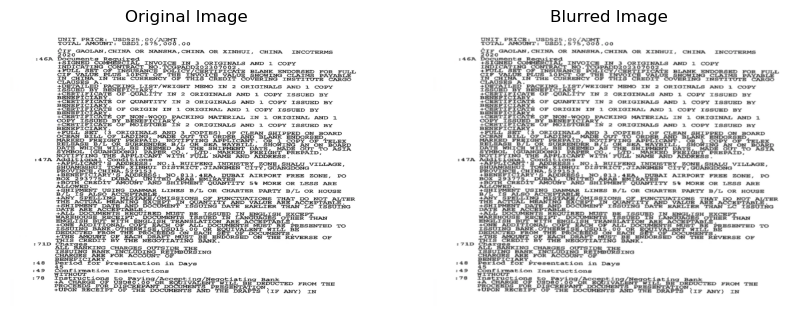

In [91]:
import cv2
from matplotlib import pyplot as plt

# Load the image
image_path = 'C:/Users/hezro/Desktop/para5.png'  # Replace with your image path
image = cv2.imread(image_path)

# Check if the image is loaded correctly
if image is None:
    print("Error loading image")
else:
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)

    # Save the blurred image
    output_path = 'C:/Users/hezro/Desktop/para5_blur.png'  # Replace with the desired output path
    cv2.imwrite(output_path, blurred_image)
    print(f"Blurred image saved to {output_path}")

    # Convert the images from BGR to RGB format for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    blurred_image_rgb = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB)

    # Display the original and blurred images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Blurred Image")
    plt.imshow(blurred_image_rgb)
    plt.axis('off')

    plt.show()


# 6.0

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from wand.image import Image
from collections import Counter
from cv2 import dnn_superres

# Paths to images
image_paths = [
    'C:/Users/hezro/Desktop/OpenCV Test/Chop/chop1.png',
    
]

# Model path for super resolution
model_path = "C:/Users/hezro/Desktop/OpenCV Test/test03/FSRCNN-small_x2.pb"

# Processing each image
for index, image_path_ori in enumerate(image_paths):
    # Read the original image using OpenCV
    img_ori = cv2.imread(image_path_ori)
    
    # Check if the image is loaded correctly
    if img_ori is None:
        raise ValueError(f"Could not load image from {image_path_ori}")
   
    # Create an SR object
    sr = dnn_superres.DnnSuperResImpl_create()

    # Read image
    image = img_ori

    # Read the desired model
    sr.readModel(model_path)

    # Set the desired model and scale to get correct pre- and post-processing
    sr.setModel("fsrcnn", 3)

    # Upscale the image
    upscale_img = sr.upsample(image)

    # Save the upscaled image temporarily (because the variable "upscale_img" format is in numpy array) 
    upscaled_path = "C:/Users/hezro/Desktop/realEsrgen/chop1_FSRCNNx2.png"
    cv2.imwrite(upscaled_path, upscale_img)


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\merge.dispatch.cpp:130: error: (-215:Assertion failed) mv[i].size == mv[0].size && mv[i].depth() == depth in function 'cv::merge'
